[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/stan/jet/notebooks/Normal_Crossing_SGLD_trajectory_notebook.ipynb)

# Normal Crossing SGLD trajectory notebook

This notebook uses SGLD to sample from the posterior around a point, for a polynomial model characterized by $y_{pred} = w_1^a * w_2^b * x$ for some $(a, b)$, where $w_1$ and $w_2$ are weights to be learned and $x$ is our (1-dimensional) input.

Both the input $x$ and target data $y$ are generated using (independent) gaussian noise, and the loss is Mean Squared Error from $y$ to $y_{pred}$, so the model achieves its lowest loss when $w_1=0$ or $w_2=0$.


#Setup (skippable)

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install git+https://github.com/timaeus-research/devinterp.git@stan/jet
else:
    %pip uninstall devinterp -y
    %cd ..
    %pip install -e .

%pip install ipywidgets ipympl
%matplotlib widget
%load_ext autoreload
%autoreload 2

Found existing installation: devinterp 1.2.0
Uninstalling devinterp-1.2.0:
  Successfully uninstalled devinterp-1.2.0
Note: you may need to restart the kernel to use updated packages.
/home/svwin/devinterp
Obtaining file:///home/svwin/devinterp
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for devinterp (pyproject.toml) ... done
  Created wheel for devinterp: filename=devinterp-1.2.0-0.editable-py3-none-any.whl size=3324 sha256=5fd9c7106450a819aa871e2990f6e5b606b6aea6c54daa4683dbe08b5fdadb65
  Stored in directory: /tmp/pip-ephem-wheel-cache-f1ozd9hg/wheels/bb/ea/fd/e16671b75d7d6a99197aa21701965c24d5fcd966f892e29ec1
Successfully built devinterp
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import locale


def getpreferredencoding(do_setlocale=True):
    return "UTF-8"


locale.getpreferredencoding = getpreferredencoding

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import LinearSegmentedColormap

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT
from devinterp.slt.llc import OnlineLLCEstimator
from devinterp.slt.sampler import sample
from devinterp.utils import default_nbeta, evaluate
from functools import partial

from devinterp.jet_tools.plot import *
from devinterp.jet_tools.models import *
from devinterp.jet_tools.diffs import *
from devinterp.jet_tools.utils import *

evaluate_mae = partial(evaluate, F.l1_loss)

# **Auxiliary functions**

In [3]:
# plotting
sns.set_style("whitegrid")

# plotting
CMAP = sns.color_palette("muted", as_cmap=True)
PRIMARY, SECONDARY, TERTIARY = CMAP[:3]


def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i : i + 2], 16) / 255.0 for i in (0, 2, 4))


lighter_factor = 0.9  # Between 0 and 1, higher values make it closer to white
lighter_SECONDARY = tuple(
    [x + (1 - x) * lighter_factor for x in hex_to_rgb(SECONDARY)[:3]] + [1.0]
)

colors = [SECONDARY, lighter_SECONDARY]
n_bins = 20  # Number of bins
contour_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
SEED = 0
SIGMA = 1
NUM_TRAIN_SAMPLES = 1000
BATCH_SIZE = NUM_TRAIN_SAMPLES
EVALUATE = evaluate_mae

train_loader, train_data, x, y = generate_dataset_for_seed(
    seed=SEED, sigma=SIGMA, batch_size=BATCH_SIZE, num_samples=NUM_TRAIN_SAMPLES
)

# **Model definition**

In [6]:
INITIAL_PARAMETERS = [0.0, 0.0]
# MSE loss function and zero-mean gaussian, so this is effectively w_1**2A * w_2**2B as loss, NB
A_B = [1, 3]

nbeta = default_nbeta(len(train_data))  # = n/log(n)
# model = PolyModel(torch.tensor(A_B).to(DEVICE), DEVICE).to(DEVICE)
model = PolyModelNoData(torch.tensor(A_B).to(DEVICE), DEVICE).to(DEVICE)
# model = SumModel(torch.tensor(A_B).to(DEVICE), DEVICE).to(DEVICE)
# model = SumModelNoData(torch.tensor(A_B).to(DEVICE), DEVICE).to(DEVICE)
model.weights = nn.Parameter(
    torch.tensor(INITIAL_PARAMETERS, dtype=torch.float32, requires_grad=True).to(DEVICE)
)

# **SGLD trajectories sampling**


In [7]:
sampling_method = SGLD
# Number and length of chains
num_chains_sgld = 1
num_draws_sgld = 10_000

# SGLD parameters
epsilon_sgld = 0.005

In [8]:
torch.manual_seed(SEED)
np.random.seed(SEED)
weights = WeightCallback(
    num_chains=num_chains_sgld, num_draws=num_draws_sgld, model=model
)
gradients = GradientCallback(
    num_chains=num_chains_sgld, num_draws=num_draws_sgld, model=model
)
online_llc_estimator = OnlineLLCEstimator(
    num_chains=num_chains_sgld,
    num_draws=num_draws_sgld,
    nbeta=nbeta,
    init_loss=0.0,
    device=DEVICE,
)

trace_sgld = sample(
    model,
    train_loader,
    evaluate=EVALUATE,
    optimizer_kwargs=dict(lr=epsilon_sgld, nbeta=nbeta, bounding_box_size=3.0),
    sampling_method=sampling_method,
    num_chains=num_chains_sgld,  # independent sampling runs
    num_draws=num_draws_sgld,  # length of a sampling run
    verbose=True,
    device=DEVICE,
    callbacks=[online_llc_estimator, weights, gradients],
    seed=SEED,
)

/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:225: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/utils.py:222: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return criterion(y_pred, y), {"output": y_pred}
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:264: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:291: UserWarning: You are using seeded runs, for full reproducibility check https://pytorch.org/docs/stable/notes/randomness.html
  warnings.warn(
Chain 0:   0%|          

In [ ]:
wt_sgld = np.array(weights.get_results()["ws/trace"])
gd_sgld = np.array(gradients.get_results()["grads/trace"])
# numpy running mean of llc_chain (does not work yet with multiple chains)
llc_chain = online_llc_estimator.get_results()["llc/trace"]
# llc_chain = np.cumsum(llc_chain) / np.arange(1, len(llc_chain[0]) + 1)
print(np.nonzero(np.isnan(wt_sgld)))
print(epsilon_sgld * num_draws_sgld)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
50.0


# **SGLD plots**

## **Plotting SGLD trajectories and jet coordinates**

(10000, 1, 2)


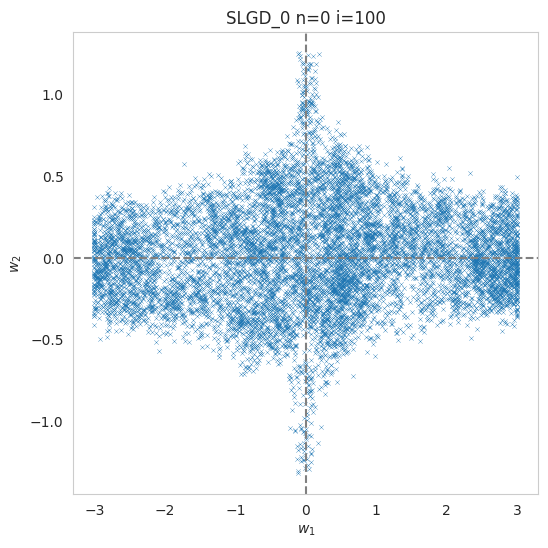

(10000, 1, 2)


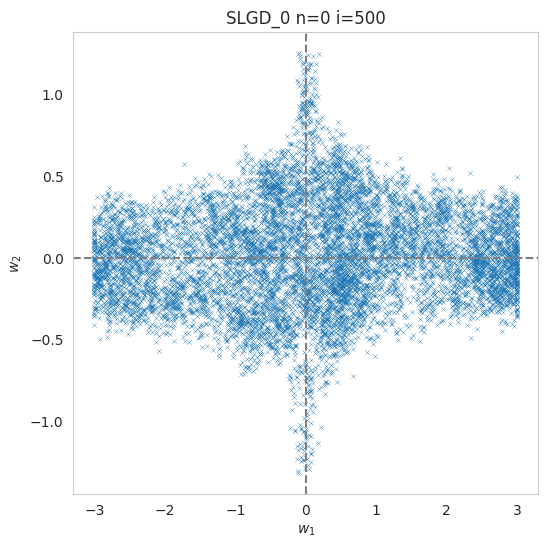

(9900, 1, 2)


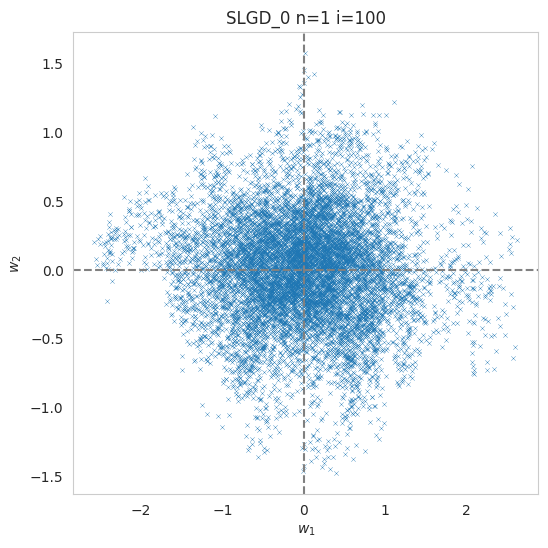

(9499, 1, 2)


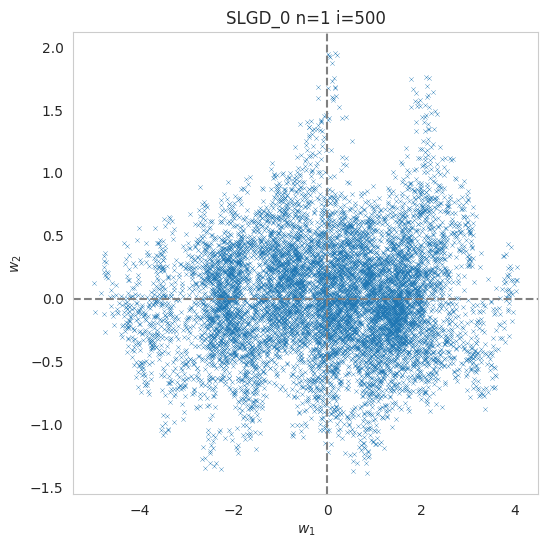

(9800, 1, 2)


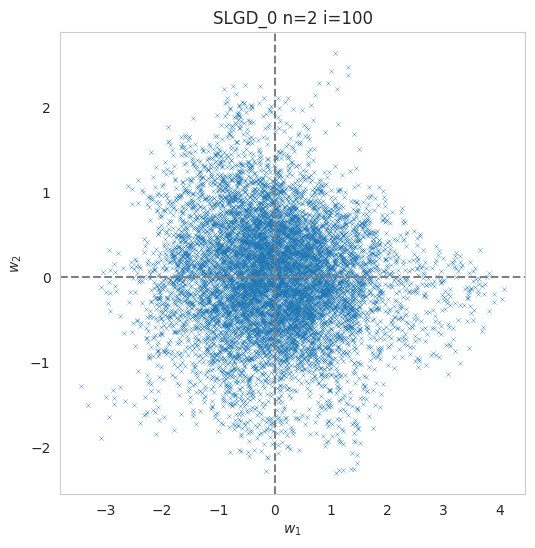

(8086, 1, 2)


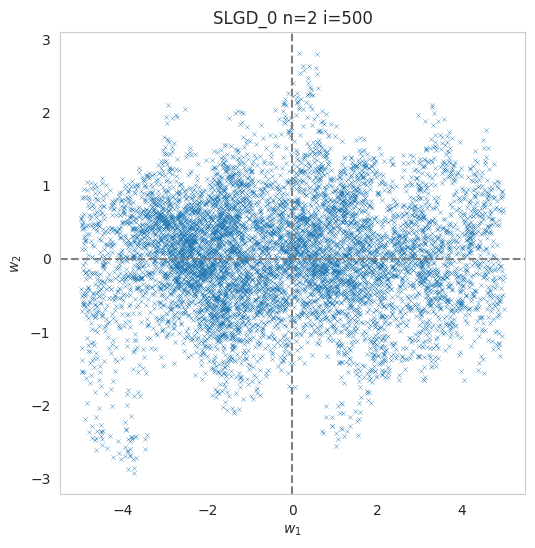

In [10]:
plot_multi_trajectories(wt_sgld, [100, 500], [0, 1, 2], f"SLGD", model=model)

## **Plot cumulant statistics of marginal distribution of jet coordinates SGLD**


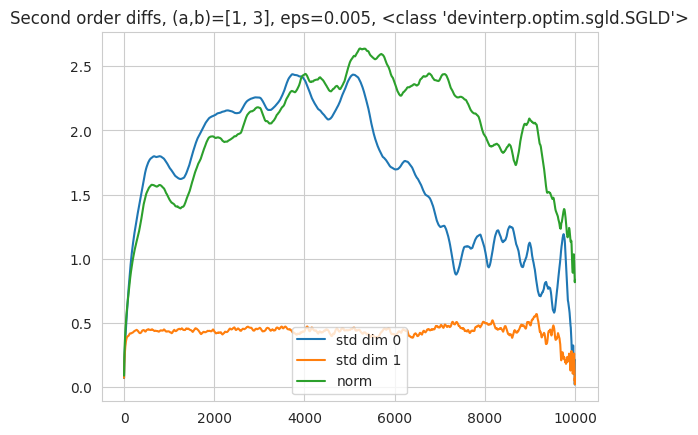

In [11]:
flattened_wts_sgld = wt_sgld.reshape((num_chains_sgld, num_draws_sgld, -1))
flattened_gds_sgld = gd_sgld.reshape((num_chains_sgld, num_draws_sgld, -1))

plot_second_order_one_place_stats(
    flattened_wts_sgld,
    1,
    title=f"Second order diffs, (a,b)={A_B}, eps={epsilon_sgld}, {sampling_method}",
)

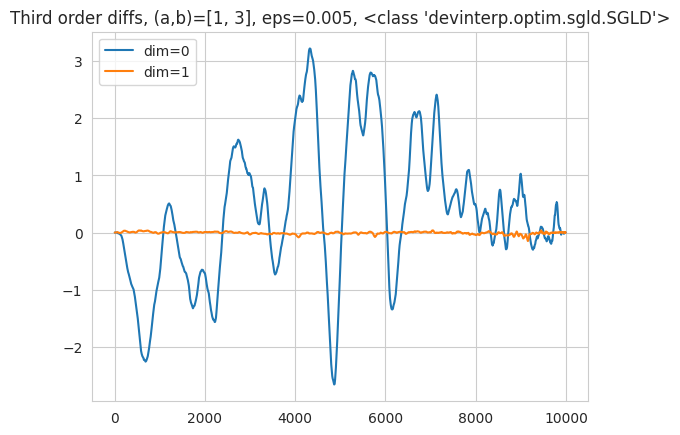

In [12]:
plot_third_order_stats_per_dim(
    flattened_wts_sgld,
    1,
    title=f"Third order diffs, (a,b)={A_B}, eps={epsilon_sgld}, {sampling_method}",
    up_to_dim=2,
)

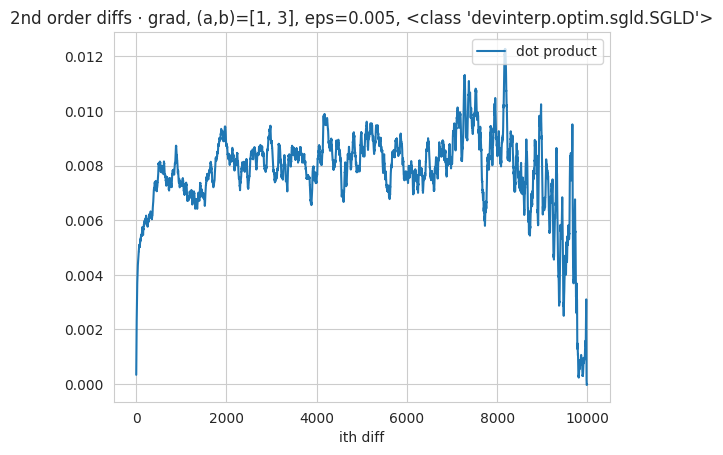

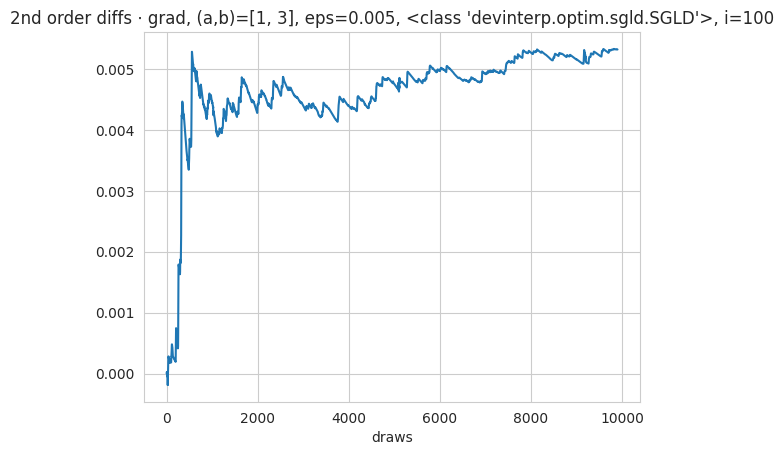

In [13]:
plot_second_order_one_place_dot_products(
    flattened_wts_sgld,
    flattened_gds_sgld,
    1,
    i_to_plot_draws_for=100,
    title=f"2nd order diffs ⋅ grad, (a,b)={A_B}, eps={epsilon_sgld}, {sampling_method}",
)

## **Vector fields SGLD**

In [75]:
plot_combined_analysis(
    flattened_wts_sgld,
    flattened_gds_sgld,
    num_bins=15,
    title=f"(a,b)={A_B}, eps={epsilon_sgld}, {sampling_method}",
)

interactive(children=(IntSlider(value=100, continuous_update=False, description='i_to_plot_for:', max=2000, mi…

# **SGHNT trajectories sampling**

In [76]:
num_chains_sgnht = 1
num_draws_sgnht = 10_000

epsilon_sgnht = 0.001

In [84]:
sgnht_weights = WeightCallback(
    num_chains=num_chains_sgnht, num_draws=num_draws_sgnht, model=model
)
online_llc_estimator = OnlineLLCEstimator(
    num_chains=num_chains_sgnht,
    num_draws=num_draws_sgld,
    nbeta=nbeta,
    init_loss=0.0,
    device=DEVICE,
)
sgnht_gradients = GradientCallback(
    num_chains=num_chains_sgnht, num_draws=num_draws_sgnht, model=model
)
sampling_method = SGNHT
trace_sgnht = sample(
    model,
    train_loader,
    evaluate=EVALUATE,
    optimizer_kwargs=dict(
        lr=epsilon_sgnht, nbeta=nbeta, diffusion_factor=0.005, bounding_box_size=3.0
    ),
    sampling_method=sampling_method,
    num_chains=num_chains_sgnht,  # independent sampling runs
    num_draws=num_draws_sgnht,  # length of a sampling run
    verbose=True,
    device=DEVICE,
    callbacks=[online_llc_estimator, sgnht_weights, sgnht_gradients],
    seed=SEED,
)

/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:225: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/utils.py:222: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return criterion(y_pred, y), {"output": y_pred}
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:264: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:291: UserWarning: You are using seeded runs, for full reproducibility check https://pytorch.org/docs/stable/notes/randomness.html
  warnings.warn(
Chain 0:   0%|          

Chain 0: 100%|██████████| 10000/10000 [01:31<00:00, 108.72it/s]
/home/svwin/devinterp/src/devinterp/slt/llc.py:149: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  self.llc_stds = self.llcs.std(dim=0)


In [85]:
wt_sgnht = np.array(sgnht_weights.get_results()["ws/trace"])
gd_sgnht = np.array(sgnht_gradients.get_results()["grads/trace"])
print(np.nonzero(np.isnan(wt_sgnht)))
print(epsilon_sgld * num_draws_sgnht)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
50.0


# **SGNHT plots**

## **Plotting SGNHT trajectories and jet coordinates**




(10000, 1, 2)


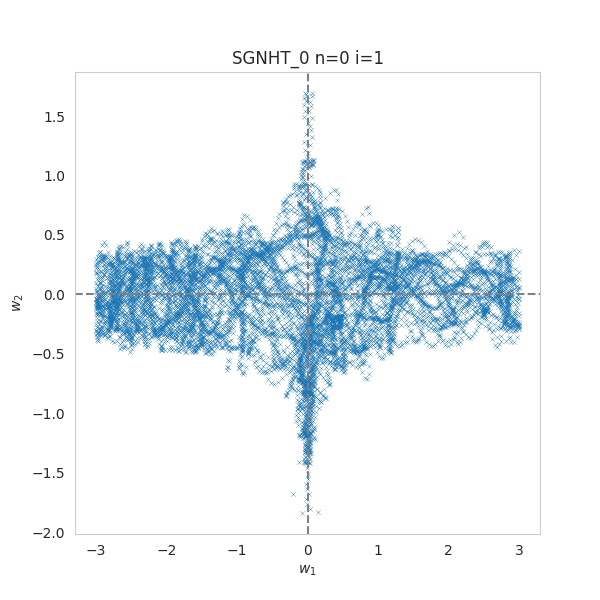

(10000, 1, 2)


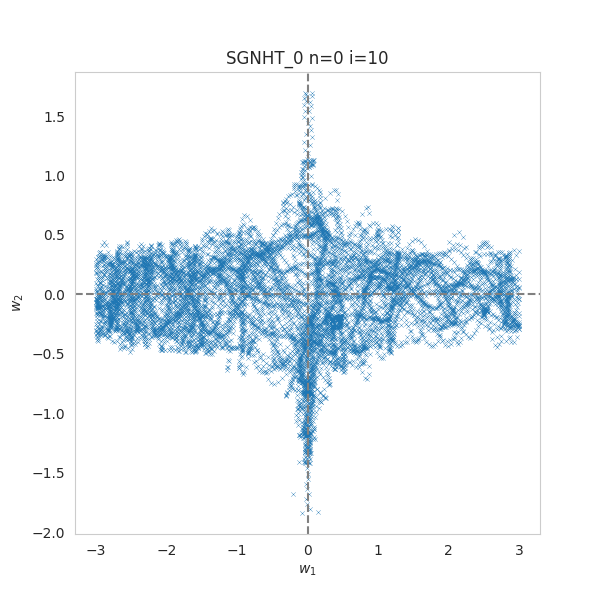

(9999, 1, 2)


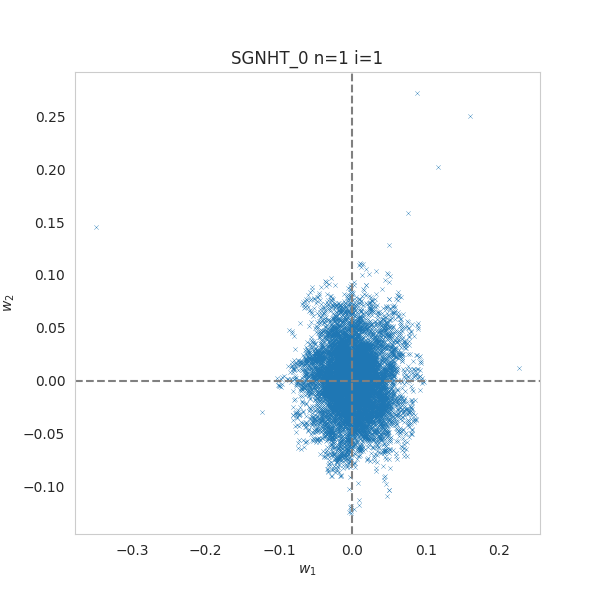

(9990, 1, 2)


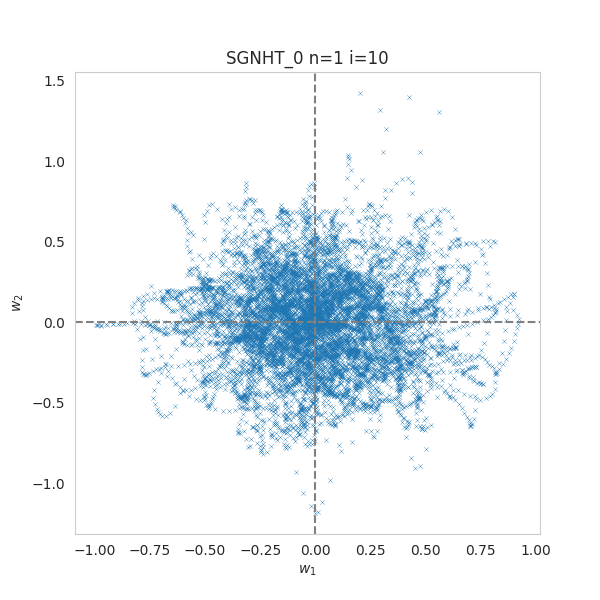

(9998, 1, 2)


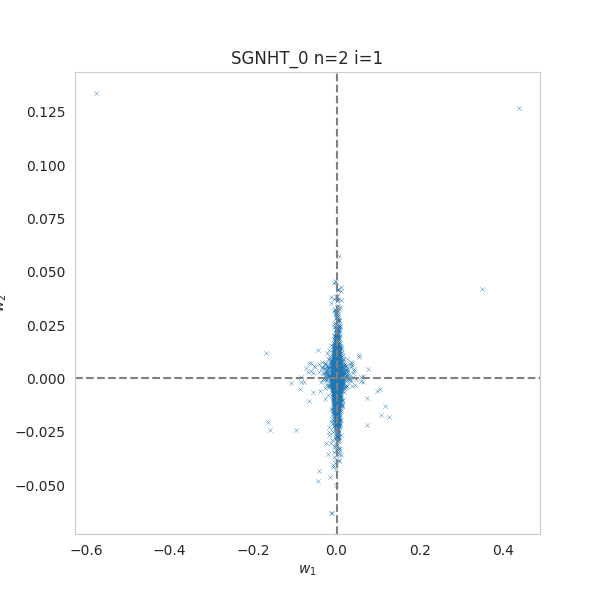

(9980, 1, 2)


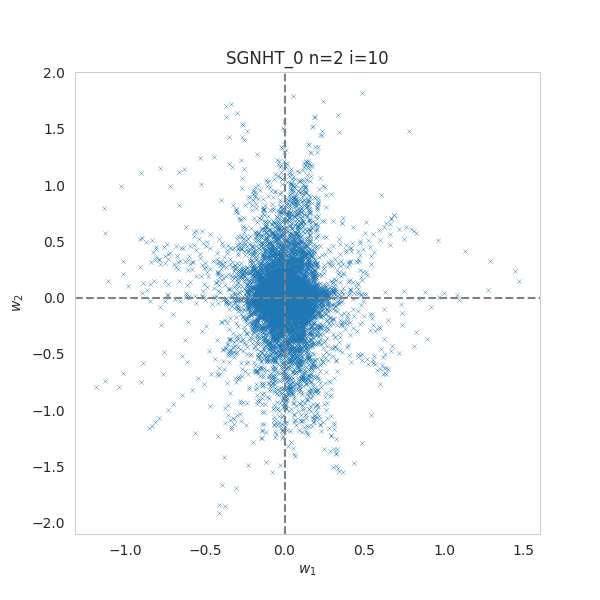

No such comm: 85ffd1415daa446284e8018ffcbab2a3


In [86]:
plot_multi_trajectories(wt_sgnht, [1, 10], [0, 1, 2], "SGNHT", model=model)

## **Plot cumulant statistics of marginal distribution of jet coordinates SGNHT**

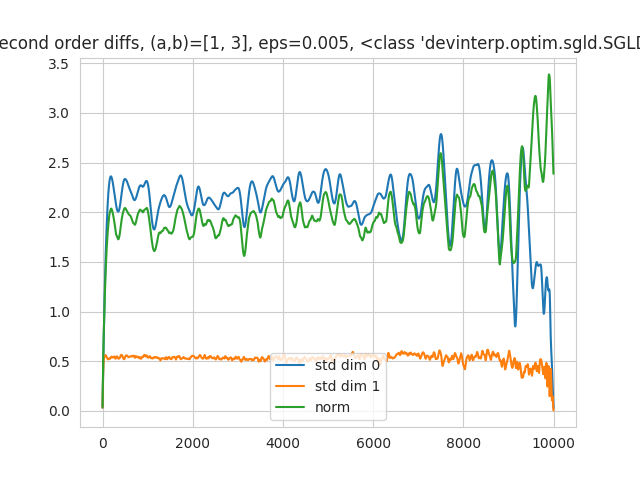

No such comm: 52dd098808754e7fb727c8d00364e6e1
No such comm: 52dd098808754e7fb727c8d00364e6e1
No such comm: 52dd098808754e7fb727c8d00364e6e1
No such comm: 52dd098808754e7fb727c8d00364e6e1
No such comm: 52dd098808754e7fb727c8d00364e6e1
No such comm: 52dd098808754e7fb727c8d00364e6e1
No such comm: 52dd098808754e7fb727c8d00364e6e1
No such comm: 52dd098808754e7fb727c8d00364e6e1
No such comm: 52dd098808754e7fb727c8d00364e6e1
No such comm: 52dd098808754e7fb727c8d00364e6e1


In [87]:
flattened_wts_sgnht = wt_sgnht.reshape((num_chains_sgnht, num_draws_sgnht, -1))
flattened_gds_sgnht = gd_sgnht.reshape((num_chains_sgnht, num_draws_sgnht, -1))

plot_second_order_one_place_stats(
    flattened_wts_sgnht,
    1,
    title=f"Second order diffs, (a,b)={A_B}, eps={epsilon_sgld}, {sampling_method}",
)

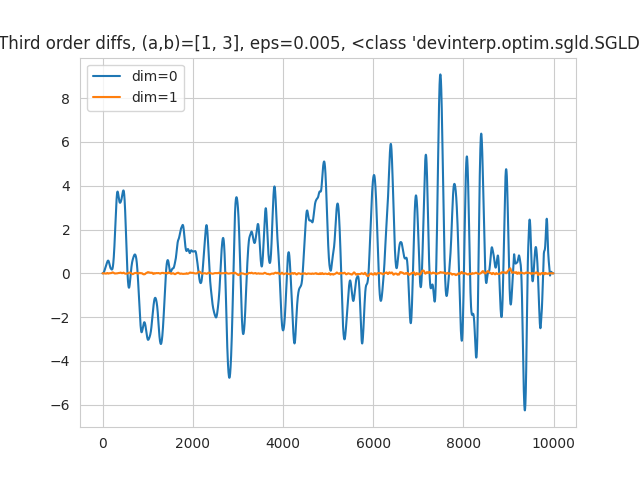

In [88]:
plot_third_order_stats_per_dim(
    flattened_wts_sgnht,
    1,
    title=f"Third order diffs, (a,b)={A_B}, eps={epsilon_sgld}, {sampling_method}",
    up_to_dim=2,
)

## **Vector fields SGNHT**

In [89]:
plot_combined_analysis(
    flattened_wts_sgnht, flattened_gds_sgnht, num_bins=15, title="SGNHT"
)

interactive(children=(IntSlider(value=100, continuous_update=False, description='i_to_plot_for:', max=2000, mi…

No such comm: a7a5883402df4fa297c8517d945a21ba
No such comm: a7a5883402df4fa297c8517d945a21ba
No such comm: a7a5883402df4fa297c8517d945a21ba
No such comm: a7a5883402df4fa297c8517d945a21ba
No such comm: a7a5883402df4fa297c8517d945a21ba
No such comm: a7a5883402df4fa297c8517d945a21ba
